## Importing Packages

In [25]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date
import seaborn as sns
from pydataset import data
from env import host, user, password
from sklearn.model_selection import train_test_split
import os
from sklearn.cluster import KMeans
from wrangle_zillow import wrangle_zillow, split_zillow, scale_data
import re
import PyPDF2
from FE_cluster import select_kbest

## Acquiring Clean Data

In [2]:
zillow = wrangle_zillow()

## Splitting the Data

In [3]:
train, validate, test = split_zillow(zillow, stratify_by = 'county')

## Explore

<AxesSubplot:xlabel='logerror_absolute', ylabel='Count'>

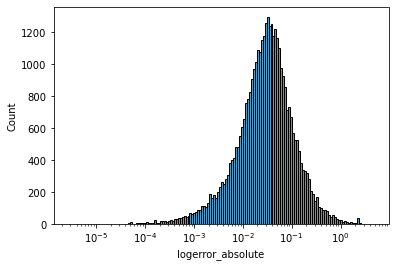

In [4]:
# Displaying a distribution of logerror

sns.histplot(train['logerror_absolute'], log_scale = True)

<AxesSubplot:xlabel='lotsizesquarefeet', ylabel='Count'>

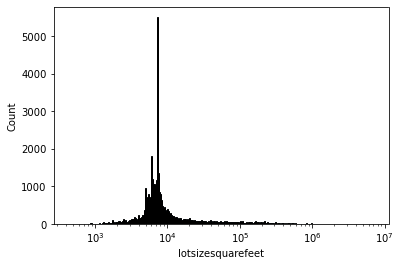

In [5]:
# Displaying assessment year distribution

sns.histplot(train['lotsizesquarefeet'], log_scale = True)

<AxesSubplot:xlabel='bathrooms', ylabel='Count'>

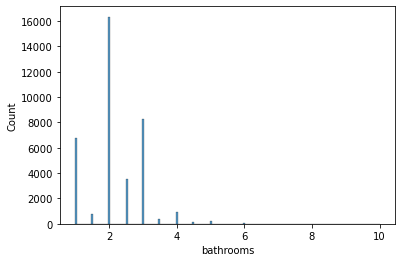

In [6]:
# Displaying a distribution of logerror

sns.histplot(train['bathrooms'])

<AxesSubplot:xlabel='county', ylabel='logerror'>

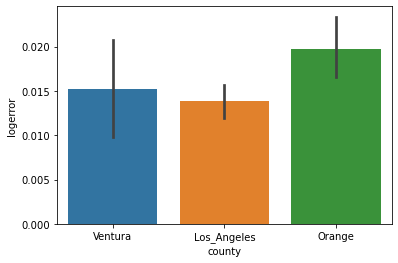

In [7]:
# Displaying the relationship between county and logerror
# Orange county has a significantly higher avereage error than the other counties, although this is average
# including over/under estimates. If we want an idea of total deviation from the true value of the property
# we have to use an absolute error to measure deviations from the true value.

sns.barplot(x = train['county'], y = train['logerror'])

<AxesSubplot:xlabel='county', ylabel='logerror_absolute'>

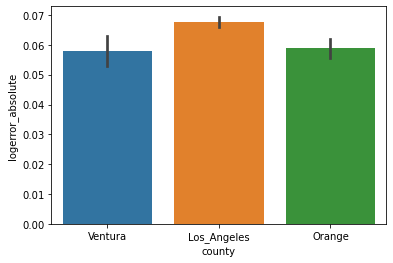

In [8]:
# Displaying the relationship between county and their relative absolute logerror
# Los Angeles seems to have a higher average absolute logerror. So estimates are least reliable when coming
# from LA. While this is useful information for reliability of estimations, as a predictor it doesn't provide
# much insight.

sns.barplot(x = train['county'], y = train['logerror_absolute'])

<AxesSubplot:xlabel='square_feet', ylabel='logerror'>

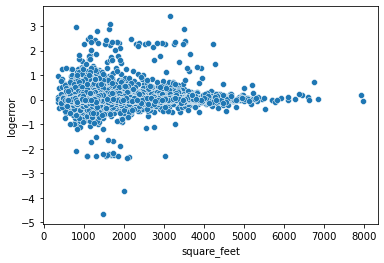

In [9]:
# Displaying relationship between square footage and logerror
# Note as square footage increases total error seems to go down

sns.scatterplot(x = train['square_feet'], y = train['logerror'])

<AxesSubplot:xlabel='tax_value', ylabel='logerror'>

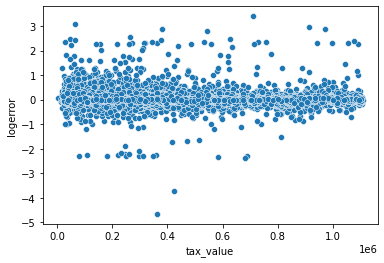

In [10]:
# Displaying relationship between square footage and logerror
# Doesn't seem to be much of a relationship here

sns.scatterplot(x = train['tax_value'], y = train['logerror'])

<AxesSubplot:xlabel='tax_rate', ylabel='logerror'>

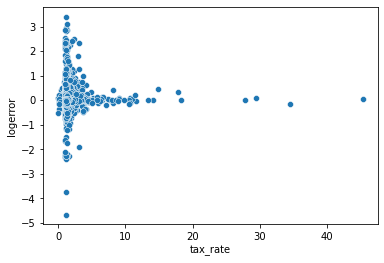

In [11]:
# Displaying relationship between tax rate and logerror
# Looks as though as tax rate increases so does accuracy, although let's see if those are just outliers

sns.scatterplot(x = train['tax_rate'], y = train['logerror'])

<AxesSubplot:xlabel='tax_rate'>

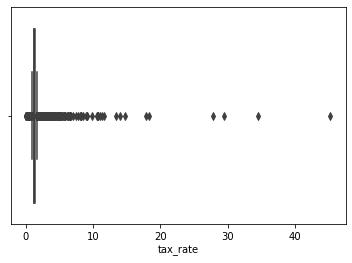

In [12]:
# Yeah those are outliers

sns.boxplot(train['tax_rate'])

<AxesSubplot:xlabel='buildingqualitytypeid', ylabel='logerror'>

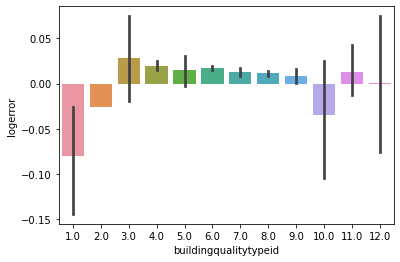

In [13]:
# Displaying relationship between building quality type and logerror

sns.barplot(x = train['buildingqualitytypeid'], y = train['logerror'])

<AxesSubplot:xlabel='square_feet', ylabel='logerror'>

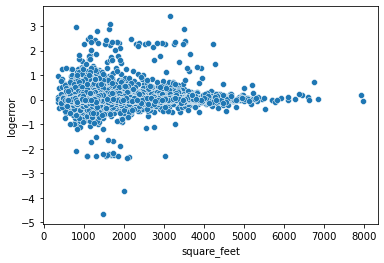

In [14]:
sns.scatterplot(x = train['square_feet'], y = train['logerror'])

<AxesSubplot:xlabel='age_in_years', ylabel='logerror'>

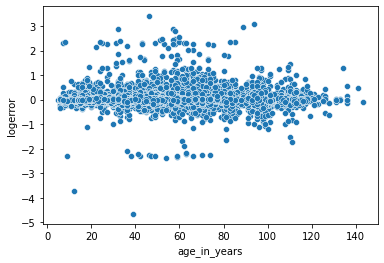

In [15]:
sns.scatterplot(x = train['age_in_years'], y = train['logerror'])

<AxesSubplot:xlabel='bathrooms', ylabel='logerror'>

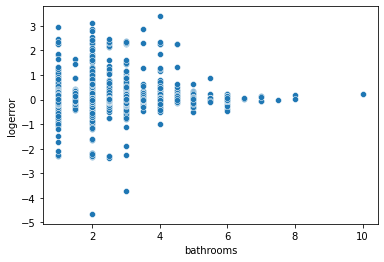

In [16]:
sns.scatterplot(x = train['bathrooms'], y = train['logerror'])

## Test 1

Is there a significant difference in the average error of Orange County and the total average error? (alpha = .05)

In [17]:
x1 = train[train['county'] == 'Orange']
x1 = x1['logerror']
x2 = train.logerror.mean()
t, p = stats.ttest_1samp(x1, x2)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = 2.452
p = 0.014


With a p-value falling below my set alpha, we can reasonably say there is a significant difference in the average logerror between Orange county and the average.

## Test 2

Is there a difference in the average log error between houses that are greater than 4000 feet and those that are less? (alpha = .05)

In [18]:
x1 = train[train['square_feet'] < 4000]
x1 = x1['logerror']
x2 = train[train['square_feet'] > 4000]
x2 = x2['logerror']
t, p = stats.ttest_ind(x1, x2)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = -3.659
p = 0.000


With a p-value falling below my set alpha, we can reasonably say there is a significant difference in the average logerror between properties with greater than 4000 and those with less.

## Test 3

Is there a difference in the average log error between houses that have more than 4 bathrooms and those that have 4 or less? (alpha = .05)

In [19]:
x1 = train[train['bathrooms'] <= 4]
x1 = x1['logerror']
x2 = train[train['square_feet'] > 4]
x2 = x2['logerror']
t, p = stats.ttest_ind(x1, x2)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = -0.301
p = 0.763


With a p-value above my alpha, we can say that there is likely no significant difference in logerror between properties with more than 4 bathrooms and those with 4 or less.

## Feature Engineering

Finding features most associated with logerror

In [20]:
feature_train = train.select_dtypes(include=['float64'])
select_kbest(feature_train.drop(columns=['logerror', 'logerror_absolute']), feature_train['logerror'], 4)

['bathrooms', 'bedrooms', 'buildingqualitytypeid', 'square_feet']

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37440 entries, 27842 to 48157
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   parcelid                    37440 non-null  int64  
 1   logerror                    37440 non-null  float64
 2   transactiondate             37440 non-null  object 
 3   bathrooms                   37440 non-null  float64
 4   bedrooms                    37440 non-null  float64
 5   buildingqualitytypeid       37440 non-null  float64
 6   square_feet                 37440 non-null  float64
 7   fips                        37440 non-null  float64
 8   latitude                    37440 non-null  float64
 9   longitude                   37440 non-null  float64
 10  lotsizesquarefeet           37440 non-null  float64
 11  rawcensustractandblock      37440 non-null  float64
 12  regionidcity                37440 non-null  float64
 13  regionidcounty             

In [22]:
dummies_orange = pd.get_dummies(train[['county']])
train = pd.concat([train, dummies_orange], axis=1)
train.drop(columns = ['county_Los_Angeles', 'county_Ventura'], inplace = True)
X = train[['county_Orange', 'square_feet', 'bathrooms']]

In [26]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)

array([0, 2, 2, ..., 2, 2, 0], dtype=int32)

In [27]:
train['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,county_Orange,square_feet,bathrooms
0,0.248321,1144.497147,1.752739
1,0.342758,3057.182387,3.276246
2,0.291892,1882.326201,2.440953


In [28]:
train

,parcelid,logerror,transactiondate,bathrooms,bedrooms,buildingqualitytypeid,square_feet,fips,latitude,longitude,...,taxes,heatingorsystemdesc,county,logerror_absolute,age_in_years,Bathrooms_cat,Bedrooms_cat,tax_rate,county_Orange,cluster
27842,17282100,-0.033406,2017-04-19,1.5,3.0,6.0,1016.0,6111.0,34193052.0,-118863596.0,...,5259.52,None,Ventura,0.033406,59.0,1.5,3,1.07,0,0
54124,12140826,0.019201,2017-07-06,2.0,4.0,7.0,2466.0,6037.0,34126581.0,-118016992.0,...,1873.58,Central,Los_Angeles,0.019201,58.0,2,4+,1.52,0,2
10773,11084015,0.017302,2017-02-17,2.0,4.0,8.0,1720.0,6037.0,34253342.0,-118515927.0,...,3380.07,Central,Los_Angeles,0.017302,62.0,2,4+,1.26,0,2
2820,14750447,-0.020634,2017-01-13,2.0,2.0,6.0,1316.0,6059.0,33791000.0,-117792000.0,...,4749.56,None,Orange,0.020634,35.0,2,2,1.11,1,0
52396,12212751,0.094821,2017-06-30,1.0,3.0,4.0,782.0,6037.0,33953524.0,-118259525.0,...,617.01,Floor/Wall,Los_Angeles,0.094821,83.0,1,3,2.03,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58755,11225759,-0.105276,2017-07-20,2.0,4.0,6.0,1300.0,6037.0,34570245.0,-117922676.0,...,1382.89,Central,Los_Angeles,0.105276,36.0,2,4+,1.29,0,0
6340,13899691,0.001819,2017-01-30,2.0,3.0,6.0,1187.0,6059.0,33402997.0,-117593968.0,...,5706.56,None,Orange,0.001819,57.0,2,3,1.00,1,0
60821,10829950,0.018417,2017-07-26,3.0,2.0,8.0,1585.0,6037.0,34199200.0,-118458000.0,...,1796.34,Central,Los_Angeles,0.018417,40.0,3,2,1.27,0,2
65947,13977911,0.012019,2017-08-14,2.5,2.0,6.0,1738.0,6059.0,33683792.0,-118003519.0,...,8997.18,None,Orange,0.012019,19.0,2.5,2,1.12,1,2
